# Iris Dataset Notebook

A] **Let's load first the Iris dataset and explore a bit. We will use the dataset directly (we could also use the scikit-learn one).**

Fisher, R. (1936). Iris [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C56C76.

<br>


In [1]:
!uv add --active --dev numpy pandas matplotlib seaborn scikit-learn catboost mlflow

Resolved 156 packages in 1.84s                                       
Prepared 6 packages in 38.03s                                            
Installed 77 packages in 506ms                              
 + alembic==1.16.2
 + annotated-types==0.7.0
 + astroid==3.3.11
 + blinker==1.9.0
 + cachetools==5.5.2
 + catboost==1.2.8
 + click==8.2.1
 + cloudpickle==3.1.1
 + contourpy==1.3.2
 + cycler==0.12.1
 + databricks-sdk==0.59.0
 + dill==0.4.0
 + docker==7.1.0
 + fastapi==0.116.0
 + flask==3.1.1
 + fonttools==4.58.5
 + gitdb==4.0.12
 + gitpython==3.1.44
 + google-auth==2.40.3
 + graphene==3.4.3
 + graphql-core==3.2.6
 + graphql-relay==3.2.0
 + graphviz==0.21
 + greenlet==3.2.3
 + gunicorn==23.0.0
 + importlib-metadata==8.7.0
 + iniconfig==2.1.0
 + isort==6.0.1
 + itsdangerous==2.2.0
 + joblib==1.5.1
 + kiwisolver==1.4.8
 + loguru==0.7.3
 + mako==1.3.10
 + matplotlib==3.10.3
 + mccabe==0.7.0
 + mlflow==3.1.1
 + mlflow-skinny==3.1.1
 + mlops==0.1.0 (from file:///home/stavros/lab/mlops)
 + na

In [2]:
import pandas as pd

df = pd.read_csv("../data/iris.csv")
print(df.head())
df.info()           # Data types, non-null counts
df.describe()       # Summary stats for numeric columns
df.describe(include='object')  # For categorical/text columns
df.value_counts("species")

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [3]:
duplicates = df[df.duplicated(keep=False)]
print(f"Total duplicate instances: {len(duplicates)}")
display(duplicates)

# Drop duplicate rows (keeping the first occurrence)
df = df.drop_duplicates()

Total duplicate instances: 2


,sepal_length,sepal_width,petal_length,petal_width,species
101,5.8,2.7,5.1,1.9,virginica
142,5.8,2.7,5.1,1.9,virginica


In [4]:
missing_summary = df.isnull().sum()
missing_percent = (missing_summary / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_percent
}).sort_values(by='Missing %', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


<br>

B] **Let's show feature correlation. We only care about numeric features in order to apply Pearson correlation. It is expected that petal length and width are highly correlated.**

<br>

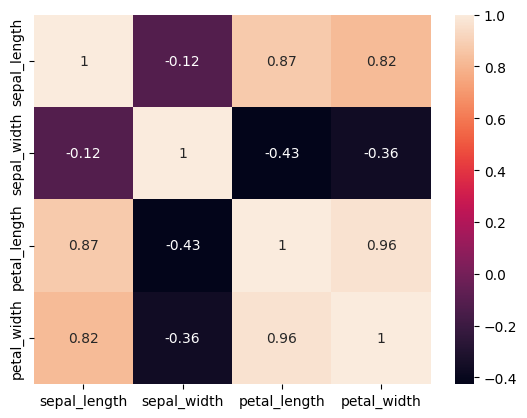

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df.select_dtypes(include=['number']).corr(method='pearson'), annot = True); 

plt.show()

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Separate features and target
target_col = 'species'  # Replace with the actual name of your target column
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode target if it's still a string
if y.dtype == 'object':
    y = y.astype('category').cat.codes

# 1. ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
anova_scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)
print("ANOVA F-scores:\n", anova_scores)


ANOVA F-scores:
 petal_length    1176.842427
petal_width      950.308977
sepal_length     121.615019
sepal_width       48.822605
dtype: float64


In [7]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X = df.drop(columns=['species'])
y = df['species'].astype('category').cat.codes

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# CatBoost
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=43)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Compare
print("CatBoost Results:")
print(classification_report(y_test, cat_preds))

print("\nRandom Forest Results:")
print(classification_report(y_test, rf_preds))

# Accuracy for CatBoost
cat_accuracy = accuracy_score(y_test, cat_preds)
print(f"CatBoost Accuracy: {cat_accuracy:.2f}")

# Accuracy for Random Forest
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

CatBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

CatBoost Accuracy: 1.00
Random Forest Accuracy: 1.00


<br>

C] **Let's do some cross-validation. It gives you a reliable estimate of how your model will perform on average on unseen data.
On the previous cell we depend on the random_state value and split. Also dump the experiments to Mlflow.**

<br>

In [8]:
import mlflow
import mlflow.catboost
import mlflow.sklearn
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

mlflow.set_tracking_uri("http://127.0.0.1:8080") 

# Load and clean data
df = pd.read_csv("../data/iris.csv")
X = df.drop(columns=['species'])
y = LabelEncoder().fit_transform(df['species'])

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'ANN (MLP)': MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000, random_state=42)
}

mlflow.set_experiment("iris_classification")

# Evaluate each with MLflow tracking
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Cross-validation scores
        acc_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(f1_score, average='macro'))

        model.fit(X, y) 
        input_example = X_train.sample(1)
        signature = infer_signature(X_train, model.predict(X_train))

        # Log params
        mlflow.log_param("model", name)

        # Log metrics (mean & std of accuracy and F1)
        mlflow.log_metric("cv_accuracy_mean", acc_scores.mean())
        mlflow.log_metric("cv_accuracy_std", acc_scores.std())
        mlflow.log_metric("cv_f1_macro_mean", f1_scores.mean())
        mlflow.log_metric("cv_f1_macro_std", f1_scores.std())

        # Optionally, log the model
        if name == "CatBoost":
            mlflow.catboost.log_model(model, name="model", input_example=input_example, signature=signature)
        else:
            mlflow.sklearn.log_model(model,  name="model", input_example=input_example, signature=signature)

        print(f"\n{name}")
        print(f"Accuracy: {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")
        print(f"F1 Macro: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")


2025/07/19 17:32:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



RandomForest
Accuracy: 0.947 ± 0.027
F1 Macro: 0.946 ± 0.027
🏃 View run RandomForest at: http://127.0.0.1:8080/#/experiments/868609974133748254/runs/1a3bc97945e140928614a7372a9aa3c3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/868609974133748254


2025/07/19 17:33:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



CatBoost
Accuracy: 0.953 ± 0.034
F1 Macro: 0.953 ± 0.034
🏃 View run CatBoost at: http://127.0.0.1:8080/#/experiments/868609974133748254/runs/2f51bd96b0f1499ba9f8765e122d42c3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/868609974133748254


2025/07/19 17:33:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



ANN (MLP)
Accuracy: 0.973 ± 0.039
F1 Macro: 0.973 ± 0.040
🏃 View run ANN (MLP) at: http://127.0.0.1:8080/#/experiments/868609974133748254/runs/f636bfd49926442ca41e8ee52c0a0a80
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/868609974133748254


<br>

D] **Pick the last model that was logged and score it as a smoke test**

<br>

In [9]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("http://127.0.0.1:8080")  # Set if remote

experiment_name = "iris_classification"
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)

# Get latest successful run
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["start_time DESC"],
    max_results=1
)

latest_run_id = runs[0].info.run_id
print(latest_run_id)

model_uri = f"runs:/{latest_run_id}/model"
print(model_uri)
# Load the model
model = mlflow.sklearn.load_model(model_uri)

# Use the same column names as training
columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# Example row (you can replace with any realistic values)
input_data = pd.DataFrame([[5.1, 3.5, 1.4, 0.2]], columns=columns)

from sklearn.preprocessing import LabelEncoder

prediction = model.predict(input_data)[0]
print("Predicted class index:", prediction)
# Load or re-fit the encoder with your original labels
encoder = LabelEncoder()
encoder.fit(["setosa", "versicolor", "virginica"])

print("Predicted species:", encoder.inverse_transform([prediction])[0])

f636bfd49926442ca41e8ee52c0a0a80
runs:/f636bfd49926442ca41e8ee52c0a0a80/model


Predicted class index: 0
Predicted species: setosa
